# AI for Earth System Science Hackathon 2020
# HOLODEC Machine Learning Challenge Problem
# Team 49
*our names*


### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| x  |  µm     |  particle horizontal position |
| y  |  µm     |  particle vertical position  |
| z  | µm  | particle position in depth (along the direction of propagation) |
| d  | µm  | particle diameter |
| hid | arbitrary | hologram ID by particle|


## Ultimate Submission Code

## Tackling the single particle problem with simple models
We have tried predicting the x and y coordinates, and the diameter, in a few ways. The main problem with this problem is the processing time. Training with 15000 images is a no-go (even the baseline model crashes). We are thus training with 6000 and validating with 2000 images. Even then, running simple models (e.g. linear regression) take too much time for the 600 by 400 pixel space (240k pixels!). Therefore we have tried several different methods of reducing the number of features we are dealing with. The key seems to be engineer the features so that we remove uncessary input information (noise) for the output we are predicting. 

<ol>
<li> Train and predict *separately* the x and y coordinates of the single particles:
Essentially, if we are predicting the x coordinate, we mean along the y axis (reducing the pixel space to 600). Conversely, if we are predicting the y coordinate, we mean along the x axis (reducing the pixel space to 400). No downscaling necessary in this method! </li> 
<li> Train with the whole 2D pixel field and predict the diameter after downscaling: we have used factor of 4 to downscale (600 by 400 pixels to 150 by 100 pixels).  </li> 
<li> Train with the whole 2D pixel field and predict separately x and y after PCA: used the first 900 components </li> 
</ol>

**Question:** can we do better with simple models than the baseline CNN? Note that compare to two baseline CNNs: one run with 15000 training samples (none of us had the memory to run this) and the other trained with 6000 (performs very poorly; we have tried different parameters/architectures to improve performance but it remains poor). 

**Short answer:** yes we can get close to CNN (trained with 15000) using Random Forest for x and y (Method 1) and Ridge regression for d (Method 2). 

**Interpretation:** Method 1 works well for x because we have removed unecessary information in y direction (noise). Similarly for y prediction (remove x information). Poor prediction for diamter because that probably needs 2D (x, y) information. Method 2 works poorly for x, y (we have given the models noisy information) but works well for diameter (uses 2D info). 

### Notes on scaling
Our given code scaled the intensity of each pixel from 0-255 to 0-1 using the min and max intensity in that image (i.e. the scaling is done independently for each image). We have been told that this is common in image processing. The reason is that if we wish to pick out particular features from many images, we don't want the brightness of each image to be a confounding influence. Thus the images are scaled by their individual brightnesses. In our case, the brightness doesn't matter when predicting x and y (and d if we get to predicting this) so we used the scaled training and validation inputs. The brightness could however affect the prediction of z so if we get to predicting this, we would want to use the unscaled intensities (0 to 255 range).

# Method 1

In [ ]:
# Module imports 
import argparse
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, max_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD
%matplotlib inline

from skimage.transform import rescale, resize, downscale_local_mean

# classifiers
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

In [ ]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals is None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- inputs.shape: {inputs.shape}")
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals

In [ ]:
# data definitions
path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
#scaler_one = MinMaxScaler()
slice_idx = 6000

In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals_one)


In [ ]:
#train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
#valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])

# scale outputs with MinMax individually so they can be inverse transformed individually
def scale_outputs(COL, train_out, valid_out):
    
    scaler = MinMaxScaler()
    
    train_out_scaled = scaler.fit_transform(train_out[[COL]])
    
    valid_out_scaled = scaler.transform(valid_out[[COL]])
    
    return (scaler, train_out_scaled, valid_out_scaled)

scaler_one_xcoord, train_outputs_scaled_one_xcoord, valid_outputs_scaled_one_xcoord=\
    scale_outputs("x", train_outputs_one[["x"]], valid_outputs_one[["x"]])

scaler_one_ycoord, train_outputs_scaled_one_ycoord, valid_outputs_scaled_one_ycoord=\
    scale_outputs("y", train_outputs_one[["y"]], valid_outputs_one[["y"]])

scaler_one_zcoord, train_outputs_scaled_one_zcoord, valid_outputs_scaled_one_zcoord=\
    scale_outputs("z", train_outputs_one[["z"]], valid_outputs_one[["z"]])

scaler_one_diamtr, train_outputs_scaled_one_diamtr, valid_outputs_scaled_one_diamtr=\
    scale_outputs("d", train_outputs_one[["d"]], valid_outputs_one[["d"]])

In [ ]:
# Plot a single image (here selected the second one)
sel_image = train_inputs_scaled_one[1,:,:,0]
plt.figure()
plt.pcolormesh(range(sel_image.shape[0]), range(sel_image.shape[1]), np.transpose(sel_image))

In [ ]:
# the below few lines averages intensity values over all y-coordinates for each x-coordinate
testplot = sel_image.mean(axis=1)
plt.figure()
plt.plot(range(sel_image.shape[0]), testplot)
# this is our method of dimension reduction and of noise reduction and hopefully what the ML models will learn during training
# we could use other functions here
# using min and max functions lose the interference pattern and the models would probably learn less

In [ ]:
# set up training and validation data for inputs, and x and y outputs separately
train_X_xcoord = train_inputs_scaled_one[...,0].mean(axis=2) # xcoord
train_Y_xcoord = train_outputs_scaled_one_xcoord

train_X_ycoord = train_inputs_scaled_one[...,0].mean(axis=1) # ycoord
train_Y_ycoord = train_outputs_scaled_one_ycoord

validation_X_xcoord = valid_inputs_scaled_one[...,0].mean(axis=2) # xcoord
validation_Y_xcoord = valid_outputs_scaled_one_xcoord

validation_X_ycoord = valid_inputs_scaled_one[...,0].mean(axis=1) # ycoord
validation_Y_ycoord = valid_outputs_scaled_one_ycoord

In [ ]:
def run_simple_model(Classifier, TrainIn, TrainOut, ValidIn, ValidOut, Scaler, COL, newaxis=False):
    
    print("running model for ", COL, " prediction")
    
    model = Classifier
    
    model.fit(TrainIn, TrainOut)
    
    print('R squared for training = ', model.score(TrainIn, TrainOut))
    
    ValidPredict = model.predict(ValidIn)
    
    print('R squared for validation = ', model.score(ValidIn, ValidOut))
    
    # assuming outupts always scaled
    if newaxis:
       # needed for random forest / gradient boosting prediction for some reason
       ValidPredictUnscaled = Scaler.inverse_transform(ValidPredict[:,np.newaxis]) 
    else:
       ValidPredictUnscaled = Scaler.inverse_transform(ValidPredict)  
    
    # calculate MAE and max error
    MAE = mean_absolute_error(valid_outputs_one[COL], ValidPredictUnscaled)
    MaxError = max_error(valid_outputs_one[COL], ValidPredictUnscaled)

    print("MAE = ",MAE," Max error = ",MaxError,"\n")
    
    return

In [ ]:
# Linear classifier with default parameters
run_simple_model(LinearRegression(),\
                train_X_xcoord, train_Y_xcoord,\
                validation_X_xcoord, validation_Y_xcoord,\
                scaler_one_xcoord, "x")

run_simple_model(LinearRegression(),\
                 train_X_ycoord, train_Y_ycoord,\
                 validation_X_ycoord, validation_Y_ycoord,\
                 scaler_one_ycoord, "y")

In [ ]:
# Ridge-linear classifier
run_simple_model(Ridge(alpha=0.001),\
                train_X_xcoord, train_Y_xcoord,\
                validation_X_xcoord, validation_Y_xcoord,\
                scaler_one_xcoord, "x")

run_simple_model(Ridge(alpha=0.001),\
                 train_X_ycoord, train_Y_ycoord,\
                 validation_X_ycoord, validation_Y_ycoord,\
                 scaler_one_ycoord, "y")

In [ ]:
# Random Forest classifier
run_simple_model(RandomForestRegressor(),\
                train_X_xcoord, train_Y_xcoord,\
                validation_X_xcoord, validation_Y_xcoord,\
                scaler_one_xcoord, "x", newaxis=True)

run_simple_model(RandomForestRegressor(),\
                 train_X_ycoord, train_Y_ycoord,\
                 validation_X_ycoord, validation_Y_ycoord,\
                 scaler_one_ycoord, "y", newaxis=True)

In [ ]:
# Gradient Boosting classifier
run_simple_model(GradientBoostingRegressor(),\
                train_X_xcoord, train_Y_xcoord,\
                validation_X_xcoord, validation_Y_xcoord,\
                scaler_one_xcoord, "x", newaxis=True)

run_simple_model(GradientBoostingRegressor(),\
                 train_X_ycoord, train_Y_ycoord,\
                 validation_X_ycoord, validation_Y_ycoord,\
                 scaler_one_ycoord, "y", newaxis=True)

# Method 2

In [ ]:
# Downscaling by factor (value of 1 leaves image unchanged)
Downscale_Factor = 4

train_inputs_scaled_one_DSIZE = np.array([downscale_local_mean(train_inputs_scaled_one[i,:,:,0], (Downscale_Factor, Downscale_Factor)) for i in range(train_inputs_scaled_one.shape[0])])
print(train_inputs_scaled_one_DSIZE.shape)

valid_inputs_scaled_one_DSIZE = np.array([downscale_local_mean(valid_inputs_scaled_one[i,:,:,0], (Downscale_Factor, Downscale_Factor)) for i in range(valid_inputs_scaled_one.shape[0])])
print(valid_inputs_scaled_one_DSIZE.shape)

In [ ]:
# Plot a single image (here selected the second one)
sel_image = train_inputs_scaled_one[1,:,:,0]
plt.figure()
plt.pcolormesh(range(sel_image.shape[0]), range(sel_image.shape[1]), np.transpose(sel_image))

In [ ]:
# Compare to downsized image
sel_image = train_inputs_scaled_one_DSIZE[1,:,:]
plt.figure()
plt.pcolormesh(range(sel_image.shape[0]), range(sel_image.shape[1]), np.transpose(sel_image))

In [ ]:
# set up training and validation data. this notebook is mainly intended to predict diamter but all output variables included here for testing
train_X = train_inputs_scaled_one_DSIZE.reshape(train_inputs_scaled_one_DSIZE.shape[0], train_inputs_scaled_one_DSIZE.shape[1]*train_inputs_scaled_one_DSIZE.shape[2]) 
train_Y_xcoord = train_outputs_scaled_one_xcoord # to predict x-coord
train_Y_ycoord = train_outputs_scaled_one_ycoord # to predict y-coord
train_Y_zcoord = train_outputs_scaled_one_zcoord # to predict z-coord
train_Y_diamtr = train_outputs_scaled_one_diamtr # to predict diameter

validation_X = valid_inputs_scaled_one_DSIZE.reshape(valid_inputs_scaled_one_DSIZE.shape[0], valid_inputs_scaled_one_DSIZE.shape[1]*valid_inputs_scaled_one_DSIZE.shape[2])
validation_Y_xcoord = valid_outputs_scaled_one_xcoord # to predict x-coord
validation_Y_ycoord = valid_outputs_scaled_one_ycoord # to predict y-coord
validation_Y_zcoord = valid_outputs_scaled_one_zcoord # to predict z-coord
validation_Y_diamtr = valid_outputs_scaled_one_diamtr # to predict diameter

In [ ]:
# Linear classifier with default parameters
run_simple_model(LinearRegression(),\
                train_X, train_Y_diamtr,\
                validation_X, validation_Y_diamtr,\
                scaler_one_diamtr, "d")

In [ ]:
# Ridge linear classifier with default parameters
run_simple_model(Ridge(alpha=10),\
                train_X, train_Y_diamtr,\
                validation_X, validation_Y_diamtr,\
                scaler_one_diamtr, "d")

# Method 3

In [ ]:
### Let me try PCA again

from sklearn.decomposition import PCA

train_inputs_scaled_one_reshaped = np.reshape(train_inputs_scaled_one[...,0], 
                                              (train_inputs_scaled_one.shape[0],train_inputs_scaled_one.shape[1]*train_inputs_scaled_one.shape[2]))
valid_inputs_scaled_one_reshaped = np.reshape(valid_inputs_scaled_one[...,0], 
                                              (valid_inputs_scaled_one.shape[0],valid_inputs_scaled_one.shape[1]*valid_inputs_scaled_one.shape[2]))

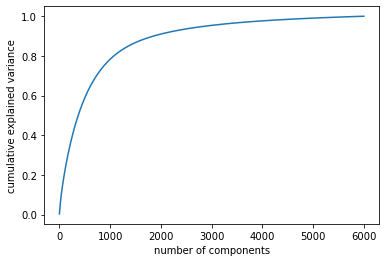

In [ ]:
pca = PCA().fit(train_inputs_scaled_one)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
# this takes a loooooong time to run (~20min)

In [ ]:
%%time
# from the above graph it looks like with ~1000 components we can capture 80% of variance, and ~3000 components about 90%
# transform train_inputs_scaled_one, and valid_inputs_scaled_one
ncomps = 900
PCA_obj = PCA(n_components=ncomps)
pca = PCA_obj.fit(train_inputs_scaled_one_reshaped)
components = pca.transform(train_inputs_scaled_one_reshaped)
components_valid = pca.transform(valid_inputs_scaled_one_reshaped)

CPU times: user 17min 34s, sys: 23 s, total: 17min 57s
Wall time: 4min 56s


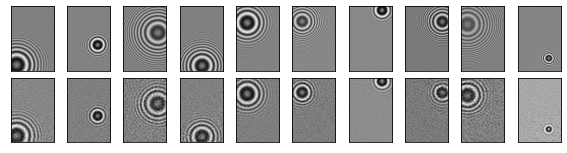

In [ ]:
# Visualize the transformation - train
projected = pca.inverse_transform(components)

fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0, i].imshow(train_inputs_scaled_one[i].reshape((600, 400)), cmap='binary_r') # True
    ax[1, i].imshow(projected[i].reshape((600, 400)), cmap='binary_r') # Predicted using 1000 components

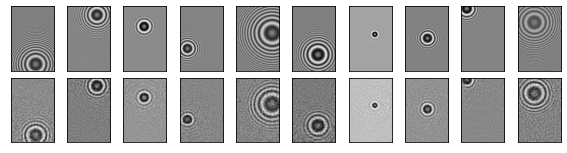

In [ ]:
# Visualize the transformation
projected_valid = pca.inverse_transform(components_valid)

# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(10):
    ax[0, i].imshow(valid_inputs_scaled_one[i].reshape((600, 400)), cmap='binary_r') # True
    ax[1, i].imshow(projected_valid[i].reshape((600, 400)), cmap='binary_r') # Predicted using 1000 components

In [ ]:
## LR for an individual variable ('x' as an example)
from sklearn.linear_model import LinearRegression
#from sklear.metrics import 
X_train = components
y_train = train_outputs_one.x # training for only 'x'
X_test = components_valid
y_test = valid_outputs_one.x

LR = LinearRegression(fit_intercept = False)
LR.fit(X_train, y_train)
train_outputs_one_LR = LR.predict(X_train)
valid_outputs_one_LR = LR.predict(X_test)
rsq_train = LR.score(X_train, y_train)
rsq_valid = LR.score(X_test, y_test)
mae_train = mean_absolute_error(y_train, train_outputs_one_LR)
mae_valid = mean_absolute_error(y_test, valid_outputs_one_LR)
maxerr_train = max_error(y_train, train_outputs_one_LR)
maxerr_valid = max_error(y_test, valid_outputs_one_LR)

print('Training:')
print(f"R^2: {rsq_train:,.2f} \t\t MAE: {mae_train:,.0f} µm \t\t Max Error: {maxerr_train:,.0f} µm")
print('Validation:')
print(f"R^2: {rsq_valid:,.2f} \t\t MAE: {mae_valid:,.0f} µm \t\t Max Error: {maxerr_valid:,.0f} µm")

# can change 'x' to predict other variables; 'y' predictions have similar performance, but 'd' and 'z' are both poor.
# also tried Lasso and Ridge; neither helped much in improving the scores.

Training:
R^2: 0.74 		 MAE: 198 µm 		 Max Error: 855 µm
Validation:
R^2: 0.67 		 MAE: 220 µm 		 Max Error: 1,031 µm


In [ ]:
# RF for an individual variable
RF = RandomForestRegressor()
# trying to control overfitting by setting max_depth=50, min_samples_split=20, min_samples_leaf=10
# RF = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=50, 
#                            min_samples_split=20, min_samples_leaf=10, min_weight_fraction_leaf=0.0, 
#                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                            min_impurity_split=None, bootstrap=True, oob_score=False, 
#                            n_jobs=None, random_state=seed, verbose=0, 
#                            warm_start=False, ccp_alpha=0.0, max_samples=None)
RF.fit(components, train_outputs_one.x)
train_outputs_one_pred = RF.predict(components)
valid_outputs_one_pred = RF.predict(components_valid)

rsq_train = RF.score(components, train_outputs_one.x)
rsq_valid = RF.score(components_valid, train_outputs_one.x)
mae_train = mean_absolute_error(train_outputs_one.x, train_outputs_one_pred)
mae_valid = mean_absolute_error(valid_outputs_one.x, valid_outputs_one_pred)
maxerr_train = max_error(train_outputs_one.x, train_outputs_one_pred)
maxerr_valid = max_error(valid_outputs_one.x, valid_outputs_one_pred)

print('Training:')
print(f"R^2: {rsq_train:,.2f} \t\t MAE: {mae_train:,.0f} µm \t\t Max Error: {maxerr_train:,.0f} µm")
print('Validation:')
print(f"R^2: {rsq_valid:,.2f} \t\t MAE: {mae_valid:,.0f} µm \t\t Max Error: {maxerr_valid:,.0f} µm")

## Results:
### For x:
# Training:
# R^2: 1.00 		 MAE: 18 µm 		 Max Error: 363 µm
# Validation:
# R^2: 0.96 		 MAE: 49 µm 		 Max Error: 938 µm

### For y:
# Training:
# R^2: 0.99 		 MAE: 18 µm 		 Max Error: 264 µm
# Validation:
# R^2: 0.95 		 MAE: 46 µm 		 Max Error: 592 µm

In [ ]:
# DNN Method

In [ ]:
#model defintion 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(256, input_dim=400, activation="linear"))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="softmax"))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               102656    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 234,497
Trainable params: 234,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# data definitions
path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 6000

In [ ]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals_one = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)
print(scaler_vals_one)
valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals_one)

# MinMaxScaler for outputs - WHY?
train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])

In [ ]:
X=np.reshape(train_inputs_scaled_one, (6000, 240000))
Y=train_outputs_scaled_one
X_test=np.reshape(valid_inputs_scaled_one, (6000, 240000))
Y_test=valid_outputs_scaled_one

In [ ]:
%%time
hist= model.fit(x_train, train_Y_ycoord, epochs=10, batch_size=30)

In [ ]:
Y_pred = model.predict(validation_X_ycoord)
print('R squared for training = ', model.evaluate(X, Y))
print('R squared for validation = ', model.evaluate(X_test, Y_test))